# Efficient Posterior Gaussian Process Sampling

The aim of this notebook is to demonstrate how to efficiently draw samples from a posterior Gaussian process (GP) following Figure 3 from  Wilson et al. <cite data-cite="wilson2020efficiently"/>. The problem of sampling naively from any GP is that it requires the generation of samples from a multivariate Gaussian as a consequence of evaluating the GP at a certain number $N^\star$ of evaluation points. However, sampling from a multivariate Gaussian with dimension $N^\star$ scales cubically with $N^\star$ because it requires a Cholesky decomposition of the $N^\star \times N^\star$ covariance matrix. More formally, drawing a sample $\textbf{f}$ from a multivariate Gaussian $\mathcal{N}(\boldsymbol{\mu}, \boldsymbol{\Sigma})$ with mean $\boldsymbol{\mu}$ and covariance $\boldsymbol{\Sigma}$ can be accomplished via

$$ \textbf{f} = \boldsymbol{\mu} + \text{chol} (\boldsymbol{\Sigma}) \textbf{z}  \; \text{ where }  \; \textbf{z} \sim \mathcal{N}(\textbf{0}, \textbf{I}),$$

with $\text{chol}$ referring to Cholesky decomposition.

Under certain assumptions, inference problems can have a posterior GP, for example, in a simple regression problem with real-valued labels, i.i.d. training data $\{(X_n, y_n)\}_{n=1,...,N}$ and a univariate Gaussian observation model of the form $p(y_n| f(X_n), \sigma_\epsilon^2)$ (with mean $f(X_n)$ and variance $\sigma_\epsilon^2$, and where $f(X_n)$ refers to evaluating a random GP function $f(\cdot)$ at $X_n$). Drawing a sample $\textbf{f}^\star$ from the posterior GP at $N^\star$ evaluation points $\{X^\star_{n^\star}\}_{n^\star=1,...,N^\star}$ can then be accomplished through

$$ \textbf{f}^\star = \textbf{K}_{\textbf{f}^\star \textbf{f}} (\textbf{K}_{\textbf{f} \textbf{f}} + \sigma_\epsilon^2 \textbf{I})^{-1} \textbf{y} + \text{chol} (\textbf{K}_{\textbf{f}^\star \textbf{f}^\star} - \textbf{K}_{\textbf{f}^\star \textbf{f}} (\textbf{K}_{\textbf{f} \textbf{f}} + \sigma_\epsilon^2 \textbf{I})^{-1} \textbf{K}_{\textbf{f} \textbf{f}^\star}) \textbf{z}  \; \text{ where }  \; \textbf{z} \sim \mathcal{N}(\textbf{0}, \textbf{I}), $$

when making use of the closed form expressions for the posterior mean and covariance (under the assumption of a zero mean prior GP for notational convenience). The terms $\textbf{K}_{\textbf{f} \textbf{f}}$, $\textbf{K}_{\textbf{f}^\star \textbf{f}}$ and $\textbf{K}_{\textbf{f} \textbf{f}^\star}$ refer to (cross-)covariance matrices when evaluating the kernel $k(\cdot, \cdot^\prime)$ at training points $\{X_n\}_{n=1,...,N}$ and test points $\{X^\star_{n^\star}\}_{n^\star=1,...,N^\star}$, and $\textbf{y}$ denotes all training targets $\{y_n\}_{n=1,...,N}$ in vectorised form.

An alternative way of drawing samples from a posterior GP is by following Matheron's rule:

$$ \textbf{f}^\star = \textbf{f}^\star_{\text{prior}} + \textbf{K}_{\textbf{f}^\star \textbf{f}} (\textbf{K}_{\textbf{f} \textbf{f}} + \sigma_\epsilon^2 \textbf{I})^{-1} (\textbf{y} - \textbf{f}_{\text{prior}}) \; \text{ where } \; \begin{pmatrix}
           \textbf{f}^\star_{\text{prior}} \\
           \textbf{f}_{\text{prior}}
         \end{pmatrix} \; \sim \mathcal{N}\left(\begin{pmatrix}
           \textbf{0} \\
           \textbf{0}
         \end{pmatrix},  \begin{pmatrix}
           \textbf{K}_{\textbf{f}^\star_{\text{prior}} \textbf{f}^\star_{\text{prior}}} & \textbf{K}_{\textbf{f}^\star_{\text{prior}} \textbf{f}_{\text{prior}}} \\
           \textbf{K}_{\textbf{f}_{\text{prior}} \textbf{f}^\star_{\text{prior}}} & \textbf{K}_{\textbf{f}_{\text{prior}} \textbf{f}_{\text{prior}}}
         \end{pmatrix}\right), $$

with $\textbf{f}_{\text{prior}}$ and $\textbf{f}^\star_{\text{prior}}$ referring to random samples obtained when jointly evaluating the prior GP at both training points $\{X_n\}_{n=1,...,N}$ and evaluation points $\{X^\star_{n^\star}\}_{n^\star=1,...,N^\star}$. Note that this way of obtaining samples from the posterior GP does not alleviate the computational complexity problem in any way, because sampling $\textbf{f}_{\text{prior}}$ and $\textbf{f}^\star_{\text{prior}}$ from the prior GP has cubic complexity $\mathcal{O}((N + N^\star)^3)$.

However, you can approximate a kernel $k(\cdot,\cdot^\prime)$ with a finite number of real-valued feature functions $\phi_d(\cdot)$ indexed with $d=1,...,D$ (e.g. through Mercer's or Bochner's theorem) as:

$$k(X,X^\prime) \approx \sum_{d=1}^D \phi_d(X) \phi_d({X^\prime}).$$

This enables you to approximate Matheron's rule with help of the weight space view:

$$\textbf{f}^\star \approx \boldsymbol{\Phi}^\star \textbf{w} + \boldsymbol{\Phi}^\star \boldsymbol{\Phi}^\intercal(\boldsymbol{\Phi} \boldsymbol{\Phi}^\intercal + \sigma_\epsilon^2 \textbf{I})^{-1}(\textbf{y} - \boldsymbol{\Phi} \textbf{w}) \; \text{ where } \; \textbf{w} \sim \mathcal{N}(\textbf{0}, \textbf{I}),$$

with $\boldsymbol{\Phi}$ referring to the $N \times D$ feature matrix evaluated at the training points $\{X_n\}_{n=1,...,N}$ and $\boldsymbol{\Phi}^\star$ to the $N^\star \times D$ feature matrix evaluated at the test points $\{X^\star_{n^\star}\}_{n^\star=1,...,N^\star}$. The quantities $\boldsymbol{\Phi}^\star \boldsymbol{\Phi}^\intercal$ and $\boldsymbol{\Phi} \boldsymbol{\Phi}^\intercal$ are weight space approximations of the exact kernel matrices $\textbf{K}_{\textbf{f}^\star \textbf{f}}$ and $\textbf{K}_{\textbf{f} \textbf{f}}$ respectively. The weight space Matheron representation enables you to sample more efficiently with a complexity of $\mathcal{O}(D)$ that scales only linearly with the number of feature functions $D$ (because the standard normal weight prior's diagonal covariance matrix can be linearly Cholesky decomposed). The problem is that many feature functions are required in order to approximate the exact posterior reasonably well in areas most relevant for extrapolation (i.e. close but not within the training data), as shown by Wilson et al. and as reproduced in another `gpflux` notebook.

To provide a remedy, Wilson et al. propose a "hybrid" sampling scheme that enables the approximation of samples from a GP posterior in a computationally efficient fashion but with better accuracy compared to the vanilla weight space Matheron rule:

$$\textbf{f}^\star \approx \boldsymbol{\Phi}^\star \textbf{w} + \textbf{K}_{\textbf{f}^\star \textbf{f}} (\textbf{K}_{\textbf{f} \textbf{f}} + \sigma_\epsilon^2 \textbf{I})^{-1}(\textbf{y} - \boldsymbol{\Phi} \textbf{w}) \; \text{ where } \; \textbf{w} \sim \mathcal{N}(\textbf{0}, \textbf{I}),$$

that combines both feature approximations and exact kernel evaluations from the Matheron function and weight space approximation formulas above.

The subsequent experiments demonstrate the qualitative efficiency of the hybrid rule when compared to the vanilla Matheron weight space approximation, in terms of the Wasserstein distance to the exact posterior GP. To conduct these experiments, the required classes in `gpflux` are `RandomFourierFeaturesCosine`, to approximate a stationary kernel with finitely many random Fourier features $\phi_d(\cdot)$ according to Bochner's theorem and following Rahimi and Recht "Random features for large-scale kernel machines" (NeurIPS, 2007), and `KernelWithFeatureDecomposition`, to approximate a kernel with a specified set of feature functions.

In [1]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20, 3)
plt.rc("text")
plt.rcParams.update({"font.size": 16})

import numpy as np
import tensorflow as tf

from gpflow.config import default_float
from gpflow.kernels import RBF, Matern52
from gpflow.models import GPR

from gpflux.layers.basis_functions.fourier_features import RandomFourierFeaturesCosine
from gpflux.sampling.kernel_with_feature_decomposition import KernelWithFeatureDecomposition

2021-11-05 16:48:56.862815: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/hostedtoolcache/Python/3.7.12/x64/lib
2021-11-05 16:48:56.862852: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


The first set of parameters specifies settings that remain constant across different experiments. The second set of parameters refers to settings that change across individual experiments. Eventually, there are going to be three plots that compare the weight space approximated to the hybrid Matheron rule -- each plot refers to a different input domain, and the number of input dimensions increases across plots (from left to right). In each plot, the x-axis refers to the number of training examples and the y-axis refers to the $log_{10}$ Wasserstein distance to the exact posterior GP when evaluated at the test point locations. Within each plot, the weight space approximated Matheron results are indicated in orange and the hybrid Matheron results in blue. For each approximation type, three curves are shown with a differing number of Fourier features to approximate the exact kernel.

In [2]:
# settings that are fixed across experiments
kernel_class = RBF  # choose alternatively kernel_class = Matern52
noise_variance = 1e-3  # variance of the observation model
num_test_samples = 64  # number of test samples for evaluation (1024 in the paper)
num_experiment_runs = 4  # number of experiment repetitions (64 in the paper)

# settings that vary across experiments
num_input_dimensions = [2, 4, 8]  # number of input dimensions
train_sample_exponents = [2, 4, 6, 8, 10]  # num_train_samples = 2 ** train_sample_exponents
num_train_samples = [2 ** train_sample_exponent for train_sample_exponent in train_sample_exponents]
num_features = [
    1024,
    4096,
    16384,
]  # the actual number of features is num_features += num_train_samples

The method below computes the mean and the covariance matrix of an exact GP posterior when evaluated at test point locations. Note that you can also use this method to analytically compute predictions of the Matheron weight space approximated posterior GP when passing a `KernelWithFeatureDecomposition` object that approximates a kernel with feature functions.

In [3]:
def compute_analytic_GP_predictions(X, y, kernel, noise_variance, X_star):
    """
    Identify the mean and covariance of an analytic GPR posterior for test point locations.

    :param X: The train point locations, with a shape of [N x D].
    :param y: The train targets, with a shape of [N x 1].
    :param kernel: The kernel object.
    :param noise_variance: The variance of the observation model.
    :param X_star: The test point locations, with a shape of [N* x D].

    :return: The mean and covariance of the noise-free predictions,
        with a shape of [N*] and [N* x N*] respectively.
    """
    gpr_model = GPR(data=(X, y), kernel=kernel, noise_variance=noise_variance)

    f_mean, f_var = gpr_model.predict_f(X_star, full_cov=True)
    f_mean, f_var = f_mean[..., 0], f_var[0]
    assert f_mean.shape == (X_star.shape[0],)
    assert f_var.shape == (X_star.shape[0], X_star.shape[0])

    return f_mean, f_var

The method below analytically computes the mean and the covariance matrix of an approximated posterior GP evaluated at test point locations when using the hybrid Matheron rule explained above.

In [4]:
def compute_hybrid_rule_predictions(X, y, exact_kernel, approximate_kernel, noise_variance, X_star):
    """
    Identify the mean and covariance using the hybrid Matheron approximation of the exact posterior.

    :param X: The train point locations, with a shape of [N x D].
    :param y: The train targets, with a shape of [N x 1].
    :param exact_kernel: The exact kernel object.
    :param approximate_kernel: The approximate kernel object based on feature functions.
    :param noise_variance: The variance of the observation model.
    :param X_star: The test point locations, with a shape of [N* x D].

    :return: The mean and covariance of the noise-free predictions,
        with a shape of [N*] and [N* x N*] respectively.
    """
    phi_star = approximate_kernel._feature_functions(X_star)
    assert phi_star.shape[0] == X_star.shape[0]

    phi = approximate_kernel._feature_functions(X)
    assert phi.shape[0] == X.shape[0]

    kXstarX = exact_kernel.K(X_star, X)
    assert kXstarX.shape == (X_star.shape[0], X.shape[0])

    KXX = exact_kernel.K(X)
    kXX_plus_noise_var = tf.linalg.set_diag(KXX, tf.linalg.diag_part(KXX) + noise_variance)
    assert kXX_plus_noise_var.shape == (X.shape[0], X.shape[0])

    kXX_inv_mul_phi = tf.linalg.solve(kXX_plus_noise_var, phi)
    assert kXX_inv_mul_phi.shape[0] == X.shape[0]

    kXX_inv_mul_y = tf.linalg.solve(kXX_plus_noise_var, y)
    assert kXX_inv_mul_y.shape[0] == X.shape[0]

    f_mean = kXstarX @ kXX_inv_mul_y
    f_mean = f_mean[..., 0]
    assert f_mean.shape[0] == X_star.shape[0]

    f_var_sqrt = phi_star - kXstarX @ kXX_inv_mul_phi
    assert f_var_sqrt.shape[0] == X_star.shape[0]

    f_var = f_var_sqrt @ tf.transpose(f_var_sqrt)
    assert f_var.shape == (X_star.shape[0], X_star.shape[0])

    return f_mean, f_var

Our main evaluation metric is the decadic logarithm of the Wasserstein distance between an approximated GP (either with the weight space or the hybrid Matheron rule) and the exact posterior GP when evaluated at test points. For two multivariate Gaussian distributions $\mathcal{N}(\boldsymbol{\mu}_1, \boldsymbol{\Sigma}_1)$ and $\mathcal{N}(\boldsymbol{\mu}_2, \boldsymbol{\Sigma}_2)$, the Wasserstein distance $d_{\text{WS}} (\boldsymbol{\mu}_1, \boldsymbol{\Sigma}_1, \boldsymbol{\mu}_2, \boldsymbol{\Sigma}_2)$ has an analytic expression:

$$ d_{\text{WS}} (\boldsymbol{\mu}_1, \boldsymbol{\Sigma}_1, \boldsymbol{\mu}_2, \boldsymbol{\Sigma}_2) = \sqrt{|| \boldsymbol{\mu}_1 - \boldsymbol{\mu}_2 ||_2^2 + \text{trace} \left(\boldsymbol{\Sigma}_1 + \boldsymbol{\Sigma}_2 - 2 (\boldsymbol{\Sigma}_1^{1/2} \boldsymbol{\Sigma}_2 \boldsymbol{\Sigma}_1^{1/2})^{1/2}\right)}, $$

where $||\cdot||_2$ refers to the $L_2$ norm, $\text{trace}$ to the matrix trace operator and a power of $1/2$ to the matrix square root operation (i.e. for a square matrix $\textbf{M}$ it holds that $\textbf{M} = \textbf{M}^{1/2}\textbf{M}^{1/2}$).

In [5]:
def log10_Wasserstein_distance(
    mean, covariance, approximate_mean, approximate_covariance, jitter=1e-12
):
    """
    Identify the decadic logarithm of the Wasserstein distance based on the means and covariance matrices.

    :param mean:The analytic mean, with a shape of [N*].
    :param covariance: The analytic covariance, with a shape of [N* x N*].
    :param approximate_mean: The approximate mean, with a shape of [N*].
    :param approximate_covariance: The approximate covariance, with a shape of [N* x N*].
    :param jitter: The jitter value for numerical robustness.

    :return: A scalar log distance value.
    """
    squared_mean_distance = tf.norm(mean - approximate_mean) ** 2
    square_root_covariance = tf.linalg.sqrtm(
        covariance + tf.eye(tf.shape(covariance)[0], dtype=covariance.dtype) * jitter
    )
    matrix_product = square_root_covariance @ approximate_covariance @ square_root_covariance
    square_root_matrix_product = tf.linalg.sqrtm(
        matrix_product + tf.eye(tf.shape(matrix_product)[0], dtype=matrix_product.dtype) * jitter
    )
    term = covariance + approximate_covariance - 2 * square_root_matrix_product
    trace = tf.linalg.trace(term)
    ws_distance = (squared_mean_distance + trace) ** 0.5
    log10_ws_distance = tf.math.log(ws_distance) / tf.math.log(
        tf.constant(10.0, dtype=default_float())
    )
    return log10_ws_distance

The core method of the notebook conducts an individual experiment for a specified number of input dimensions, a specified number of training points (that are automatically generated) and features (to approximate the exact kernel). Subsequently, both the weight space and the hybrid Matheron rule predictions are compared to predictions of an exact posterior GP at test points (that are also automatically generated) in terms of the logarithm of the Wasserstein distance.

In [6]:
def conduct_experiment(num_input_dimensions, num_train_samples, num_features):
    """
    Compute the log10 Wassertein distance between the weight space approximated GP and the exact GP,
    and between the hybrid-rule approximated GP and the exact GP.

    :param num_input_dimensions: The number of input dimensions.
    :param num_train_samples: The number of training samples.
    :param num_features: The number of feature functions.

    :return: The log10 Wasserstein distances for both approximations.
    """
    lengthscale = (
        num_input_dimensions / 100.0
    ) ** 0.5  # adjust kernel lengthscale to the number of input dims
    num_features = num_train_samples + num_features

    # exact kernel
    exact_kernel = kernel_class(lengthscales=lengthscale)

    # weight space approximated kernel
    feature_functions = RandomFourierFeaturesCosine(
        kernel=kernel_class(lengthscales=lengthscale),
        n_components=num_features,
        dtype=default_float(),
    )
    feature_coefficients = np.ones((num_features, 1), dtype=default_float())
    approximate_kernel = KernelWithFeatureDecomposition(
        kernel=None, feature_functions=feature_functions, feature_coefficients=feature_coefficients
    )

    # create training data set and test points for evaluation
    X = []
    for i in range(num_input_dimensions):
        random_samples = np.random.uniform(low=0.15, high=0.85, size=(num_train_samples,))
        X.append(random_samples)
    X = np.array(X).transpose()

    kXX = exact_kernel.K(X)
    kXX_plus_noise_var = tf.linalg.set_diag(kXX, tf.linalg.diag_part(kXX) + noise_variance)
    lXX = tf.linalg.cholesky(kXX_plus_noise_var)
    y = tf.matmul(lXX, tf.random.normal([num_train_samples, 1], dtype=X.dtype))

    X_star = (
        []
    )  # test data is created to lie within two intervals that partially overlap with the train data
    for i in range(num_input_dimensions):
        random_samples = np.random.uniform(low=0.0, high=0.3, size=(num_test_samples,))
        indices = np.random.uniform(size=(num_test_samples,)) < 0.5
        random_samples[indices] = np.random.uniform(low=0.7, high=1.0, size=(num_test_samples,))[
            indices
        ]
        X_star.append(random_samples)
    X_star = np.array(X_star).transpose()

    # identify mean and covariance of the analytic GPR posterior
    f_mean_exact, f_var_exact = compute_analytic_GP_predictions(
        X=X, y=y, kernel=exact_kernel, noise_variance=noise_variance, X_star=X_star
    )

    # identify mean and covariance of the analytic GPR posterior when using the weight space approximated kernel
    f_mean_weight, f_var_weight = compute_analytic_GP_predictions(
        X=X, y=y, kernel=approximate_kernel, noise_variance=noise_variance, X_star=X_star
    )

    # identify mean and covariance using the hybrid approximation
    f_mean_hybrid, f_var_hybrid = compute_hybrid_rule_predictions(
        X=X,
        y=y,
        exact_kernel=exact_kernel,
        approximate_kernel=approximate_kernel,
        noise_variance=noise_variance,
        X_star=X_star,
    )

    # compute log10 Wasserstein distance between the exact solution and the weight space approximation
    log10_ws_dist_weight = log10_Wasserstein_distance(
        f_mean_exact, f_var_exact, f_mean_weight, f_var_weight
    )

    # compute log10 Wassertein distance between the exact solution and the hybrid approximation
    log10_ws_dist_hybrid = log10_Wasserstein_distance(
        f_mean_exact, f_var_exact, f_mean_hybrid, f_var_hybrid
    )

    # return the log Wasserstein distances for both approximations
    return log10_ws_dist_weight, log10_ws_dist_hybrid

This helper function repeats an individual experiment several times and returns the quartiles of the log Wasserstein distances between both approximations and the exact GP.

In [7]:
def conduct_experiment_for_multiple_runs(num_input_dimensions, num_train_samples, num_features):
    """
    Conduct the experiment as specified above `num_experiment_runs` times and identify the quartiles for
    the log10 Wassertein distance between the weight space approximated GP and the exact GP,
    and between the hybrid-rule approximated GP and the exact GP.

    :param num_input_dimensions: The number of input dimensions.
    :param num_train_samples: The number of training samples.
    :param num_features: The number of feature functions.

    :return: The quartiles of the log10 Wasserstein distance for both approximations.
    """
    list_of_log10_ws_dist_weight = (
        []
    )  # for the analytic solution using the weight space approximated kernel
    list_of_log10_ws_dist_hybrid = []  # for the hybrid-rule approximation
    for _ in range(num_experiment_runs):
        log10_ws_dist_weight, log10_ws_dist_hybrid = conduct_experiment(
            num_input_dimensions=num_input_dimensions,
            num_train_samples=num_train_samples,
            num_features=num_features,
        )
        list_of_log10_ws_dist_weight.append(log10_ws_dist_weight)
        list_of_log10_ws_dist_hybrid.append(log10_ws_dist_hybrid)

    log10_ws_dist_weight_quarts = np.quantile(list_of_log10_ws_dist_weight, q=(0.25, 0.5, 0.75))
    log10_ws_dist_hybrid_quarts = np.quantile(list_of_log10_ws_dist_hybrid, q=(0.25, 0.5, 0.75))
    return log10_ws_dist_weight_quarts, log10_ws_dist_hybrid_quarts

Since we conduct different experiments with different training data sizes, we need another helper method...

In [8]:
def conduct_experiment_for_different_train_data_sizes(num_input_dimensions, num_features):
    """
    Conduct the experiment as specified above for different training dataset sizes and store the results in lists.

    :param num_input_dimensions: The number of input dimensions.
    :param num_features: The number of feature functions.

    :return: The quartiles of the log10 Wasserstein distance for both approximations
    """
    list_log10_ws_dist_weight_quarts = (
        []
    )  # for the analytic solution using the weight space approximated kernel
    list_log10_ws_dist_hybrid_quarts = []  # for the hybrid-rule approximation
    for nts in num_train_samples:
        (
            log10_ws_dist_weight_quarts,
            log10_ws_dist_hybrid_quarts,
        ) = conduct_experiment_for_multiple_runs(
            num_input_dimensions=num_input_dimensions,
            num_train_samples=nts,
            num_features=num_features,
        )
        print(
            "Completed for num input dims = "
            + str(num_input_dimensions)
            + " and feature param = "
            + str(num_features)
            + " and num train samples = "
            + str(nts)
        )
        list_log10_ws_dist_weight_quarts.append(log10_ws_dist_weight_quarts)
        list_log10_ws_dist_hybrid_quarts.append(log10_ws_dist_hybrid_quarts)

    list_log10_ws_dist_weight_quarts = np.array(list_log10_ws_dist_weight_quarts).transpose()
    list_log10_ws_dist_hybrid_quarts = np.array(list_log10_ws_dist_hybrid_quarts).transpose()
    return list_log10_ws_dist_weight_quarts, list_log10_ws_dist_hybrid_quarts

...and another helper method because we repeat each setting with a different number of Fourier features.

In [9]:
def conduct_experiment_for_different_num_features(num_input_dimensions):
    """
    Conduct the experiment as specified above for a different number of feature functions, and store
    the results in lists of lists.

    :param num_input_dimensions: The number of input dimensions.

    :return: Lists of lists of quartiles of the log10 Wasserstein distance for both approximations.
    """
    list_of_weight_results = (
        []
    )  # for the analytic solution using the weight space approximated kernel
    list_of_hybrid_results = []  # for the hybrid-rule approximation
    for nf in num_features:
        weight_results, hybrid_results = conduct_experiment_for_different_train_data_sizes(
            num_input_dimensions=num_input_dimensions, num_features=nf
        )
        print()
        list_of_weight_results.append(weight_results)
        list_of_hybrid_results.append(hybrid_results)
    return list_of_weight_results, list_of_hybrid_results

Finally, we arrive at the actual plotting script that loops over settings with a different number of input dimensions.

2021-11-05 16:48:58.729789: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/hostedtoolcache/Python/3.7.12/x64/lib
2021-11-05 16:48:58.729823: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-05 16:48:58.729844: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (fv-az178-704): /proc/driver/nvidia/version does not exist
2021-11-05 16:48:58.730118: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Completed for num input dims = 2 and feature param = 1024 and num train samples = 4


Completed for num input dims = 2 and feature param = 1024 and num train samples = 16


Completed for num input dims = 2 and feature param = 1024 and num train samples = 64


Completed for num input dims = 2 and feature param = 1024 and num train samples = 256


Completed for num input dims = 2 and feature param = 1024 and num train samples = 1024



Completed for num input dims = 2 and feature param = 4096 and num train samples = 4


Completed for num input dims = 2 and feature param = 4096 and num train samples = 16


Completed for num input dims = 2 and feature param = 4096 and num train samples = 64


Completed for num input dims = 2 and feature param = 4096 and num train samples = 256


Completed for num input dims = 2 and feature param = 4096 and num train samples = 1024



Completed for num input dims = 2 and feature param = 16384 and num train samples = 4


Completed for num input dims = 2 and feature param = 16384 and num train samples = 16


Completed for num input dims = 2 and feature param = 16384 and num train samples = 64


Completed for num input dims = 2 and feature param = 16384 and num train samples = 256


2021-11-05 16:49:18.863151: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 142606336 exceeds 10% of free system memory.
2021-11-05 16:49:18.894657: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 142606336 exceeds 10% of free system memory.
2021-11-05 16:49:18.930459: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 142606336 exceeds 10% of free system memory.


2021-11-05 16:49:19.189066: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 142606336 exceeds 10% of free system memory.
2021-11-05 16:49:19.220058: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 142606336 exceeds 10% of free system memory.


Completed for num input dims = 2 and feature param = 16384 and num train samples = 1024



Completed for num input dims = 4 and feature param = 1024 and num train samples = 4


Completed for num input dims = 4 and feature param = 1024 and num train samples = 16


Completed for num input dims = 4 and feature param = 1024 and num train samples = 64


Completed for num input dims = 4 and feature param = 1024 and num train samples = 256


Completed for num input dims = 4 and feature param = 1024 and num train samples = 1024



Completed for num input dims = 4 and feature param = 4096 and num train samples = 4


Completed for num input dims = 4 and feature param = 4096 and num train samples = 16


Completed for num input dims = 4 and feature param = 4096 and num train samples = 64


Completed for num input dims = 4 and feature param = 4096 and num train samples = 256


Completed for num input dims = 4 and feature param = 4096 and num train samples = 1024



Completed for num input dims = 4 and feature param = 16384 and num train samples = 4


Completed for num input dims = 4 and feature param = 16384 and num train samples = 16


Completed for num input dims = 4 and feature param = 16384 and num train samples = 64


Completed for num input dims = 4 and feature param = 16384 and num train samples = 256


Completed for num input dims = 4 and feature param = 16384 and num train samples = 1024



Completed for num input dims = 8 and feature param = 1024 and num train samples = 4


Completed for num input dims = 8 and feature param = 1024 and num train samples = 16


Completed for num input dims = 8 and feature param = 1024 and num train samples = 64


Completed for num input dims = 8 and feature param = 1024 and num train samples = 256


Completed for num input dims = 8 and feature param = 1024 and num train samples = 1024



Completed for num input dims = 8 and feature param = 4096 and num train samples = 4


Completed for num input dims = 8 and feature param = 4096 and num train samples = 16


Completed for num input dims = 8 and feature param = 4096 and num train samples = 64


Completed for num input dims = 8 and feature param = 4096 and num train samples = 256


Completed for num input dims = 8 and feature param = 4096 and num train samples = 1024



Completed for num input dims = 8 and feature param = 16384 and num train samples = 4


Completed for num input dims = 8 and feature param = 16384 and num train samples = 16


Completed for num input dims = 8 and feature param = 16384 and num train samples = 64


Completed for num input dims = 8 and feature param = 16384 and num train samples = 256


Completed for num input dims = 8 and feature param = 16384 and num train samples = 1024



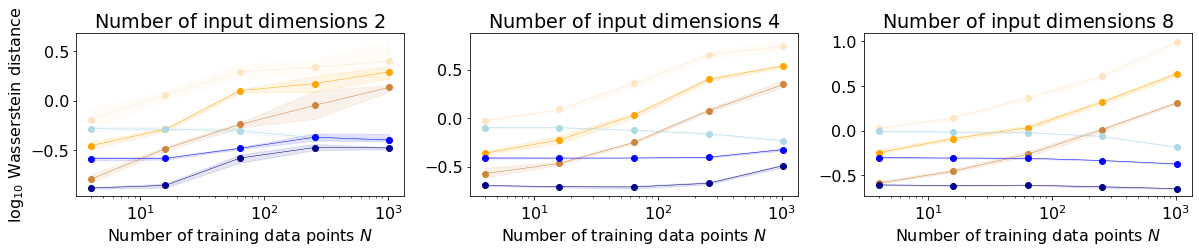

In [10]:
# create plots
fig, axs = plt.subplots(1, len(num_input_dimensions))
for i in range(len(num_input_dimensions)):
    axs[i].set_title(f"Number of input dimensions ${num_input_dimensions[i]}$")
    axs[i].set_xlabel("Number of training data points $N$")
    axs[i].set_xscale("log")
axs[0].set_ylabel(r"$\log_{10}$ Wasserstein distance")

# conduct experiments and plot results
for i in range(
    len(num_input_dimensions)
):  # iterate through the different number of input dimensions
    weight_results, hybrid_results = conduct_experiment_for_different_num_features(
        num_input_dimensions=num_input_dimensions[i]
    )

    # plot the results for the analytic solution using the weight space approximated kernel
    colors = ["bisque", "orange", "peru"]
    assert len(colors) == len(num_features), "Number of colors must equal the number of features!"
    for j in range(len(weight_results)):
        weight_result = weight_results[j]
        axs[i].fill_between(
            num_train_samples, weight_result[0], weight_result[2], color=colors[j], alpha=0.1
        )
        axs[i].plot(num_train_samples, weight_result[1], "o", color=colors[j])
        axs[i].plot(num_train_samples, weight_result[1], color=colors[j], linewidth=0.5)

    # plot the results for the hybrid-rule approximation
    colors = ["lightblue", "blue", "darkblue"]
    assert len(colors) == len(num_features), "Number of colors must equal the number of features!"
    for j in range(len(hybrid_results)):
        hybrid_result = hybrid_results[j]
        axs[i].fill_between(
            num_train_samples, hybrid_result[0], hybrid_result[2], color=colors[j], alpha=0.1
        )
        axs[i].plot(num_train_samples, hybrid_result[1], "o", color=colors[j])
        axs[i].plot(num_train_samples, hybrid_result[1], color=colors[j], linewidth=0.5)

# show plots
plt.show()

There are three plots with the number of input dimensions increasing from the left to the right. In each plot, the x-axis refers to the number of training points $N$ and the y-axis to the $\log_{10}$ Wasserstein distance between the exact GP posterior and the approximated posterior GP. Each plot has two different sets of curves: orange curves refer to experiments with a weight space approximated posterior GP and blue curves to exeriments with a hybrid-rule approximated posterior GP. Each set of curves contains different repetitions for a different number of random Fourier feature functions used for approximating the exact kernel (many features are indicated with dark colours and fewer features with lighter colours).

We see that the weight space approximated GP decreases in prediction quality as the training data increases -- this effect is more severe for higher-dimensional input domains compared to lower-dimensional input domains. On the other hand, the hybrid-rule approximated GP maintains good prediction quality as the input dimension and training data increases in our experiments. As expected, more features lead to better results resulting in a lower value for the log Wasserstein distance.